## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import os
import tensorflow as tf
os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"]="4"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()


def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")
GPU=["GPU:0","GPU:1"]

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  NVIDIA T1000 || GPU || 2.1 GiB
 /device:GPU:1 ||  Quadro P620 || GPU || 1.3 GiB


In [2]:
strategy = tf.distribute.MirroredStrategy(devices=GPU,cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [3]:
config = tf.compat.v1.ConfigProto(gpu_options= tf.compat.v1.GPUOptions(allow_growth=True))
# allow_growth=True is the important part here

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score
from random import sample

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50 
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

## Do some early processing of your metadata for easier model training:

In [5]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('data1/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('D:/AIandHealthcare/udacity/2dimage/xRAY/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
34465,00009071_000.png,No Finding,0,9071,55,F,PA,2500,2048,0.168,0.168,NaN,D:/AIandHealthcare/udacity/2dimage/xRAY/data\i...
82227,00020213_087.png,Effusion,87,20213,72,F,AP,3056,2544,0.139,0.139,NaN,D:/AIandHealthcare/udacity/2dimage/xRAY/data\i...
34824,00009189_006.png,Effusion|Infiltration|Pleural_Thickening,6,9189,68,F,PA,2570,2991,0.143,0.143,NaN,D:/AIandHealthcare/udacity/2dimage/xRAY/data\i...


In [6]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_xray_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_xray_labels = [x for x in all_xray_labels if len(x)>0]
print("Number of labels: {}\nLabels: {}".format(len(all_xray_labels),", ".join(all_xray_labels)))

for c_label in all_xray_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df.sample(3)
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

Number of labels: 15
Labels: Atelectasis, Cardiomegaly, Consolidation, Edema, Effusion, Emphysema, Fibrosis, Hernia, Infiltration, Mass, No Finding, Nodule, Pleural_Thickening, Pneumonia, Pneumothorax


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
55156,00013812_008.png,Atelectasis,8,13812,82,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45527,00011683_011.png,No Finding,11,11683,56,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
64984,00016048_000.png,No Finding,0,16048,62,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df["pneumonia_class"] = all_xray_df["Pneumonia"].map(lambda pneumonia: "yes" if pneumonia == 1.0 else "no")
all_xray_df["pneumonia_class"] = all_xray_df["pneumonia_class"].astype(str)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
68374,00016882_006.png,No Finding,6,16882,37,F,PA,2670,2697,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
91466,00022816_006.png,No Finding,6,22816,48,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
42360,00010897_005.png,No Finding,5,10897,47,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no


## Create your training and testing data:

In [8]:
def create_splits(data):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo\\\\
    pneumonia_positives = data[data.Pneumonia==1]
    train_df, valid_df = skl.train_test_split(pneumonia_positives, test_size = 0.2, stratify = pneumonia_positives['Pneumonia'])
    
    # Get index of positive
    p_inds = train_df[train_df.Pneumonia==1].index.tolist()
    # Get index of negative
    np_inds = data[data.Pneumonia==0].index.tolist()

    # Our train data should have the equal size between Pneumonia and Non-Pneumonia
    np_sample = sample(np_inds,len(p_inds))
    train_data = data.loc[p_inds + np_sample]
    
    # Remove the np_inds from our data
    new_data = data.drop(np_sample)
    
    # Get index of positive
    p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
    # Get index of negative
    np_inds = data[data.Pneumonia==0].index.tolist()

    # The validate data should reflect the real world situation. Hence, it is not balanced
    # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
    np_sample = sample(np_inds,4*len(p_inds))
    val_data = data.loc[p_inds + np_sample]
 
    return train_data, val_data

In [9]:
train_data, val_data = create_splits(all_xray_df)

In [10]:
print("Number of positive case in train data: {} = {}%".format(train_data['Pneumonia'].sum(), train_data['Pneumonia'].sum()/len(train_data)*100))
print("Number of positive case in validate data: {} = {}%".format(val_data['Pneumonia'].sum(), val_data['Pneumonia'].sum()/len(val_data)*100))

Number of positive case in train data: 1144.0 = 50.0%
Number of positive case in validate data: 287.0 = 20.0%


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [11]:
def image_augmentation(rescale_only = False):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    if rescale_only:
        # Note that the validation data should not be augmented! 
        # We only want to do some basic intensity rescaling here
        idg = ImageDataGenerator(rescale=1. / 255.0)
    else:
        idg = ImageDataGenerator(rescale=1. / 255.0,
                                  horizontal_flip = True, 
                                  vertical_flip = False, 
                                  height_shift_range= 0.1, 
                                  width_shift_range=0.1, 
                                  rotation_range=20, 
                                  shear_range = 0.1,
                                  zoom_range=0.1)
    return idg


def make_train_gen(idg, train_df, x_col='path', y_col='pneumonia_class', target_size=(224, 224), batch_size=16):
    
    ## Create the actual generators using the output of image_augmentation for our training data
        
    train_gen = idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = x_col,
                                         y_col = y_col,
                                         class_mode = 'binary',
                                         target_size = target_size, 
                                         batch_size = batch_size
                                         )

    return train_gen


def make_val_gen(idg, val_df, x_col='path', y_col='pneumonia_class', target_size=(224, 224), batch_size=16):
    
    val_gen = idg.flow_from_dataframe(dataframe=val_df, 
                                             directory=None, 
                                             x_col = x_col,
                                             y_col = y_col,
                                             class_mode = 'binary',
                                             target_size = target_size, 
                                             batch_size = batch_size
                                             )
    return val_gen

In [12]:
train_idg = image_augmentation()
train_gen = make_train_gen(train_idg, train_data)

val_idg = image_augmentation(rescale_only=True)
val_gen = make_val_gen(val_idg, val_data)

Found 2288 validated image filenames belonging to 2 classes.
Found 1435 validated image filenames belonging to 2 classes.


In [13]:
#Generate a big batch of validation data
valX, valY = val_gen.next()

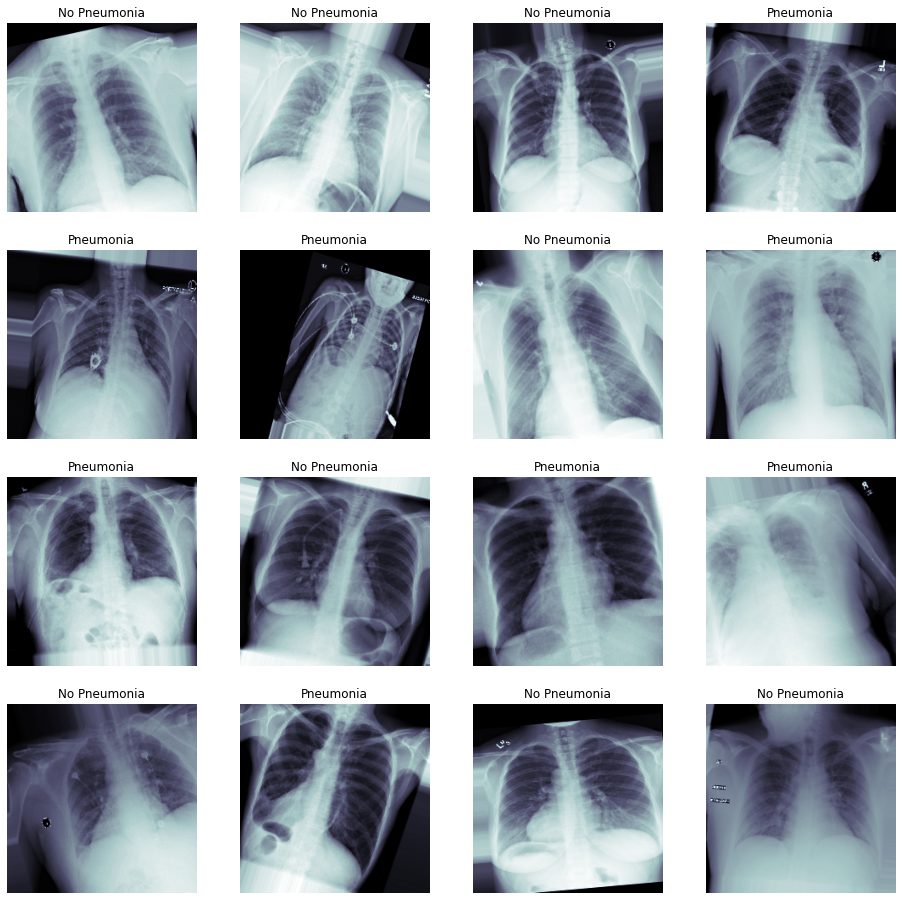

In [14]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [17]:
with strategy.scope():
    model = tf.keras.applications.ResNet50(include_top=True,
                                           weights='imagenet')
    output=model.layers[-1].output
    output=tf.keras.layers.Flatten()(output)
    model = Model(inputs = model.input, outputs = output)
    for layer in model.layers:
        layer.trainable = False
    model.summary()
    new_model = Sequential()
    new_model.add(model)
#    new_model.add(Flatten())
#   new_model.add(Dropout(0.5))
#   new_model.add(Dense(1024, activation='relu'))
#   new_model.add(Dropout(0.5))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dense(1, activation='sigmoid'))  
    new_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [18]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1000)              25636712  
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 26,280,809
Trainable params: 644,097
Non-trainable params: 25,636,712
_________________________________________________________________


In [19]:

## Below is some helper code that will allow you to add checkpoints to your model
## This will save the 'best' version of your model by comparing it to previous epochs of training
## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                            monitor= 'val_loss', 
                            verbose=1, 
                            save_best_only=True, 
                            mode= 'auto', 
                            save_weights_only = True)
early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'auto', 
                      patience=10)         
        
callbacks_list = [checkpoint, early]


In [ ]:
history = new_model.fit(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 25, 
                          callbacks = callbacks_list)

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = hierarchical_copy, num_packs = 1
143/143 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4991
Epoch 1: val_loss improved from inf to 0.00000, saving model to xray_class_my_model.best.hdf5
143/143 [==============================] - 72s 445ms/step - loss: 0.0000e+00 - accuracy: 0.4991 - val_loss: 0.0000e+00 - val_accuracy: 0.8750
Epoch 2/25
  4/143 [..............................] - ETA: 47s - loss: 0.0000e+00 - accuracy: 0.3750




##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 16, verbose = True)

In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fpr, tpr, _ = roc_curve(t_y, p_y)
    auc = roc_auc_score(t_y, p_y)
    
    plt.plot(fpr, tpr, label='Pneumonia (AUC: {:.3f})'.format(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("AUC Curve")
    plt.legend(['Pneumonia (AUC: {:.3f})'.format(auc)], loc='lower right')
    plt.show()
    return

In [ ]:


plot_auc(valY, pred_Y)



Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
def plot_history(history):
    plt.plot(history.history['binary_accuracy'], label='train_acc')
    plt.plot(history.history['val_binary_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model accuracy')
    plt.ylabel('Loss/Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='lower right')
    plt.show()
    return

In [ ]:


plot_history(history)

In [ ]:
def plot_precision_recall_curve(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    plt.plot(recall, precision , label='Pneumonia')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title("Precision-Recall Curve")
    plt.legend(['Pneumonia'], loc='lower right')
    plt.show()

    return precision, recall, thresholds

In [ ]:
precision, recall, thresholds = plot_precision_recall_curve(valY, pred_Y)
precision = np.array(precision)
recall = np.array(recall)
f1_score = 2 * (precision*recall)/(precision+recall)

In [ ]:
def plot_score_thresholds(precision, recall, f1_score, thresholds):
    plt.plot(thresholds, precision, label='Precision')
    plt.plot(thresholds, recall, label ='Recall')
    plt.plot(thresholds, f1_score, label = 'F1_Score')
    plt.xlabel('Thresholds')
    plt.ylabel('Precision/Recall/F1')
    plt.title("Precision/Recall/F1 vs. Thresholds")
    plt.legend(['Precision', 'Recall', 'F1_Score'], loc='upper right')
    plt.show()

In [ ]:
plot_score_thresholds(precision[:-1], recall[:-1], f1_score[:-1], thresholds)

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

max_f1 = max(f1_score)
print("Max F1 Score: {}".format(max_f1))
threshold = thresholds[f1_score.argmax()]
print("Threshold corresponding to max F1: {}".format(threshold))

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 
testX, testY = val_gen.next()

fig, m_axs = plt.subplots(8, 4, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(testX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)